### Country-level Segmentation

Let's investigate how explanations for preparedness vary by country.

In [6]:
# Country-Level Preparedness Modeling
# Building off global preparedness analysis to show factor importance variation by country

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load data
data = pd.read_csv("../data/survey_data_cleaned.csv")


In [4]:

print("=== COUNTRY-LEVEL PREPAREDNESS MODELING ===")
print(f"Total observations: {len(data)}")
print(f"Countries: {data['country'].value_counts().to_dict()}")

# ============================================================================
# 1. DATA PREPARATION - USING SAME TRANSFORMATIONS AS GLOBAL MODEL
# ============================================================================

def prepare_likert_data(df):
    """Transform explicit (Likert) variables using same scaling as global model"""
    df_prep = df.copy()
    
    # Emotional: -100 to +100 with 9 points → 1 to 9
    el_cols = [col for col in df_prep.columns if col.startswith('el_')]
    for col in el_cols:
        df_prep[col] = (df_prep[col] + 100) / 25 + 1
    
    # Workplace: 0 to 100 with 5 points → 1 to 5  
    wfl_cols = [col for col in df_prep.columns if col.startswith('wfl_')]
    for col in wfl_cols:
        df_prep[col] = df_prep[col] / 25 + 1
    
    return df_prep

def prepare_fast_data(df):
    """Transform implicit (fast choice) variables using same scaling as global model"""
    df_prep = df.copy()
    
    # Emotional: -100 to +100 → -1 to +1
    es_cols = [col for col in df_prep.columns if col.startswith('es_')]
    for col in es_cols:
        df_prep[col] = df_prep[col] / 100
    
    # Workplace: 0 to 100 → 0 to 1
    wfs_cols = [col for col in df_prep.columns if col.startswith('wfs_')]
    for col in wfs_cols:
        df_prep[col] = df_prep[col] / 100
    
    return df_prep

# Create datasets using same variable selection as global models
# LIKERT MODEL VARIABLES (excluding el_lgen as per global analysis)
likert_vars = (['prep_level'] + 
               [col for col in data.columns if col.startswith('el_') and col != 'el_lgen'] +
               [col for col in data.columns if col.startswith('wfl_')] +
               ['age', 'country', 'sector'])

# FAST CHOICE MODEL VARIABLES (excluding es_fgen as per global analysis)  
fast_vars = (['prep_level'] + 
             [col for col in data.columns if col.startswith('es_') and col != 'es_fgen'] +
             [col for col in data.columns if col.startswith('wfs_')] +
             ['age', 'country', 'sector'])

# Prepare datasets
likert_data = prepare_likert_data(data[likert_vars]).dropna()
fast_data = prepare_fast_data(data[fast_vars]).dropna()

print(f"\nData prepared:")
print(f"Likert model observations: {len(likert_data)}")
print(f"Fast choice model observations: {len(fast_data)}")


=== COUNTRY-LEVEL PREPAREDNESS MODELING ===
Total observations: 4211
Countries: {'US': 1204, 'UK': 617, 'DE': 613, 'IT': 600, 'FR': 593, 'SP': 584}

Data prepared:
Likert model observations: 4210
Fast choice model observations: 4195


In [ ]:

# ============================================================================
# 2. COUNTRY-LEVEL MODEL FITTING
# ============================================================================

def fit_country_models(data, model_type="likert"):
    """Fit separate models for each country"""
    countries = data['country'].unique()
    country_models = {}
    country_results = {}
    
    # Get predictor variables (exclude outcome and grouping vars)
    predictors = [col for col in data.columns 
                 if col not in ['prep_level', 'country', 'sector', 'age']]
    
    print(f"\n=== {model_type.upper()} MODEL - COUNTRY-LEVEL RESULTS ===")
    
    for country in countries:
        country_data = data[data['country'] == country].copy()
        try:
            # Include age and sector as controls
            formula = f"prep_level ~ age + sector + {' + '.join(predictors)}"
            model = ols(formula, data=country_data).fit()
            
            country_models[country] = model
            
            # Extract all coefficient results
            results = {
                'coefficients': model.params,
                'p_values': model.pvalues,
                'r_squared': model.rsquared,
                'adj_r_squared': model.rsquared_adj,
                'n_obs': int(model.nobs)
            }
            country_results[country] = results            
        except Exception as e:
            print(f"{country}: Model fitting failed - {str(e)}")
            
    return country_models, country_results

# Fit models for both specifications
print("Fitting country-level models...")
likert_models, likert_results = fit_country_models(likert_data, "likert")
fast_models, fast_results = fit_country_models(fast_data, "fast_choice")


Fitting country-level models...

=== LIKERT MODEL - COUNTRY-LEVEL RESULTS ===
FR: R² = 0.432, Adj R² = 0.404, N = 593
DE: R² = 0.473, Adj R² = 0.449, N = 612
SP: R² = 0.515, Adj R² = 0.492, N = 584
US: R² = 0.491, Adj R² = 0.479, N = 1204
IT: R² = 0.587, Adj R² = 0.568, N = 600
UK: R² = 0.503, Adj R² = 0.480, N = 617

=== FAST_CHOICE MODEL - COUNTRY-LEVEL RESULTS ===
FR: R² = 0.314, Adj R² = 0.281, N = 592
DE: R² = 0.224, Adj R² = 0.188, N = 613
SP: R² = 0.350, Adj R² = 0.318, N = 582
US: R² = 0.362, Adj R² = 0.346, N = 1196
IT: R² = 0.366, Adj R² = 0.336, N = 598
UK: R² = 0.354, Adj R² = 0.324, N = 614


In [8]:

# ============================================================================
# 3. CROSS-VALIDATION BY COUNTRY
# ============================================================================

def cross_validate_by_country(data, model_type="likert"):
    """Cross-validate models within each country"""
    countries = data['country'].unique()
    cv_results = {}
    
    print(f"\n=== {model_type.upper()} MODEL - CROSS-VALIDATION BY COUNTRY ===")
    
    for country in countries:
        country_data = data[data['country'] == country].copy()
        
        if len(country_data) < 50:
            continue
            
        # Prepare features
        predictors = [col for col in data.columns 
                     if col not in ['prep_level', 'country', 'sector']]
        
        X = pd.get_dummies(country_data[predictors], drop_first=True)
        y = country_data['prep_level']
        
        # 5-fold CV (or fewer folds if small sample)
        n_splits = min(5, len(country_data) // 10)
        if n_splits < 3:
            continue
            
        cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        cv_scores = cross_val_score(LinearRegression(), X, y, cv=cv, scoring='r2')
        
        cv_results[country] = {
            'mean_cv_r2': cv_scores.mean(),
            'std_cv_r2': cv_scores.std(),
            'n_splits': n_splits
        }
        
        print(f"{country}: CV R² = {cv_scores.mean():.3f} ± {cv_scores.std():.3f} ({n_splits}-fold)")
    
    return cv_results

# Run cross-validation
likert_cv = cross_validate_by_country(likert_data, "likert")
fast_cv = cross_validate_by_country(fast_data, "fast_choice")



=== LIKERT MODEL - CROSS-VALIDATION BY COUNTRY ===
FR: CV R² = 0.342 ± 0.094 (5-fold)
DE: CV R² = 0.418 ± 0.041 (5-fold)
SP: CV R² = 0.449 ± 0.118 (5-fold)
US: CV R² = 0.426 ± 0.080 (5-fold)
IT: CV R² = 0.521 ± 0.048 (5-fold)
UK: CV R² = 0.431 ± 0.080 (5-fold)

=== FAST_CHOICE MODEL - CROSS-VALIDATION BY COUNTRY ===
FR: CV R² = 0.201 ± 0.095 (5-fold)
DE: CV R² = 0.126 ± 0.050 (5-fold)
SP: CV R² = 0.275 ± 0.091 (5-fold)
US: CV R² = 0.325 ± 0.050 (5-fold)
IT: CV R² = 0.248 ± 0.137 (5-fold)
UK: CV R² = 0.267 ± 0.088 (5-fold)


In [9]:

# ============================================================================
# 4. FACTOR IMPORTANCE ANALYSIS
# ============================================================================

def analyze_factor_importance(country_results, model_type="likert"):
    """Analyze how factor importance varies by country"""
    
    # Get all variables that appear in models
    all_vars = set()
    for country, results in country_results.items():
        all_vars.update(results['coefficients'].index)
    
    # Remove intercept and control variables
    predictor_vars = [var for var in all_vars 
                     if not var.startswith(('Intercept', 'age[', 'sector['))]
    
    # Create coefficient matrix
    coeff_matrix = pd.DataFrame(index=predictor_vars, columns=country_results.keys())
    pval_matrix = pd.DataFrame(index=predictor_vars, columns=country_results.keys())
    
    for country, results in country_results.items():
        for var in predictor_vars:
            if var in results['coefficients'].index:
                coeff_matrix.loc[var, country] = results['coefficients'][var]
                pval_matrix.loc[var, country] = results['pvalues'][var]
            else:
                coeff_matrix.loc[var, country] = 0
                pval_matrix.loc[var, country] = 1
    
    # Convert to numeric
    coeff_matrix = coeff_matrix.astype(float)
    pval_matrix = pval_matrix.astype(float)
    
    print(f"\n=== {model_type.upper()} MODEL - FACTOR IMPORTANCE ANALYSIS ===")
    
    # Show top variables by average absolute coefficient
    avg_abs_coeff = coeff_matrix.abs().mean(axis=1).sort_values(ascending=False)
    print(f"\nTop 10 most important factors (by average |coefficient|):")
    for i, (var, coeff) in enumerate(avg_abs_coeff.head(10).items()):
        print(f"{i+1:2d}. {var}: {coeff:.3f}")
    
    # Show variables with highest variation across countries
    coeff_std = coeff_matrix.std(axis=1).sort_values(ascending=False)
    print(f"\nTop 10 most variable factors across countries (by std dev):")
    for i, (var, std) in enumerate(coeff_std.head(10).items()):
        print(f"{i+1:2d}. {var}: {std:.3f}")
    
    return coeff_matrix, pval_matrix, avg_abs_coeff, coeff_std

# Analyze factor importance
print("Analyzing factor importance across countries...")
likert_coeff, likert_pval, likert_importance, likert_variation = analyze_factor_importance(likert_results, "likert")
fast_coeff, fast_pval, fast_importance, fast_variation = analyze_factor_importance(fast_results, "fast_choice")


Analyzing factor importance across countries...

=== LIKERT MODEL - FACTOR IMPORTANCE ANALYSIS ===

Top 10 most important factors (by average |coefficient|):
 1. el_lres_ski: 0.151
 2. el_ltra_des: 0.116
 3. el_ljou_pro: 0.100
 4. el_ltra_aut: 0.078
 5. wfl_lenjhyb: 0.074
 6. wfl_luse_skills: 0.071
 7. el_lcont_imp: 0.063
 8. wfl_lcollea: 0.061
 9. wfl_lfin_lair: 0.059
10. el_lcont_con: 0.058

Top 10 most variable factors across countries (by std dev):
 1. wfl_luse_skills: 0.088
 2. wfl_lwellcomp: 0.073
 3. wfl_lmean_full: 0.063
 4. wfl_lfin_lair: 0.061
 5. el_lcont_con: 0.050
 6. el_lcon_inc: 0.050
 7. el_ljou_pro: 0.046
 8. el_lres_fin: 0.045
 9. wfl_lexcess_wk: 0.044
10. el_ltra_des: 0.043

=== FAST_CHOICE MODEL - FACTOR IMPORTANCE ANALYSIS ===

Top 10 most important factors (by average |coefficient|):
 1. es_ftra_des: 0.569
 2. es_fjou_pro: 0.456
 3. es_fcont_imp: 0.410
 4. es_ftra_aut: 0.403
 5. es_fcont_con: 0.376
 6. es_fjou_opt: 0.369
 7. wfs_fenjhyb: 0.260
 8. es_fres_fin: 0.2


Creating visualizations...


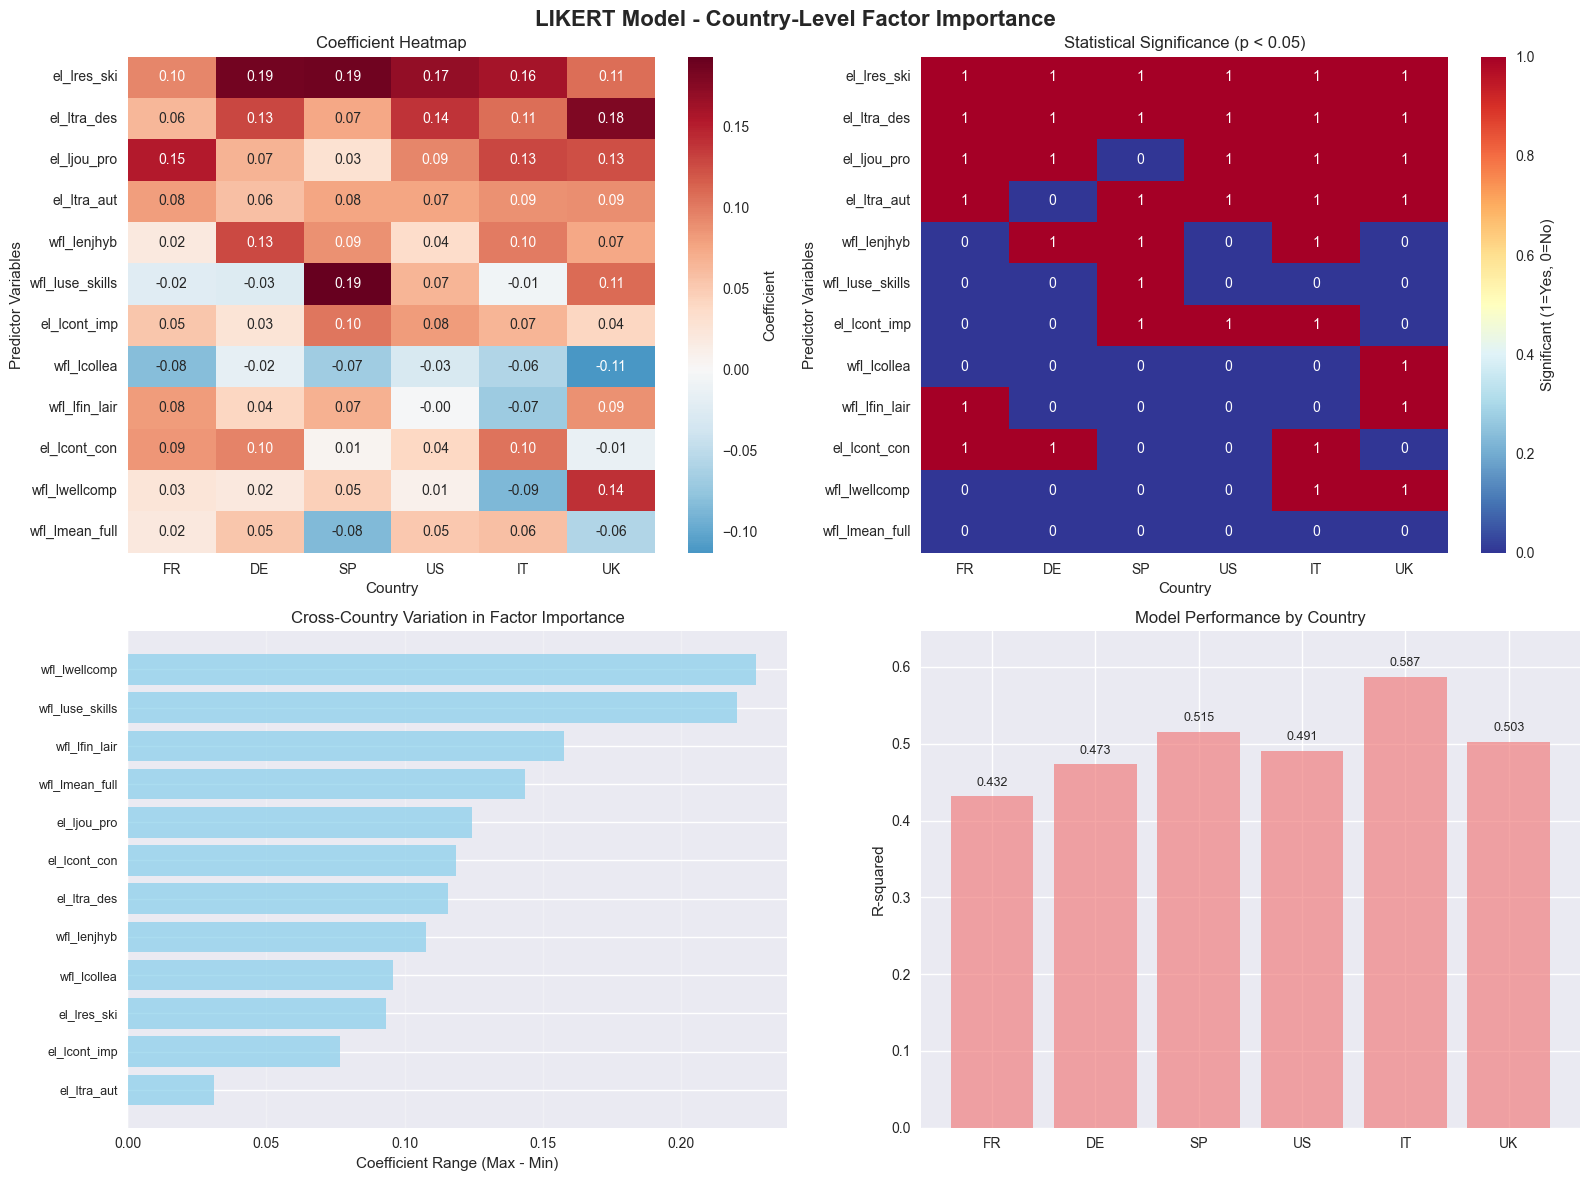

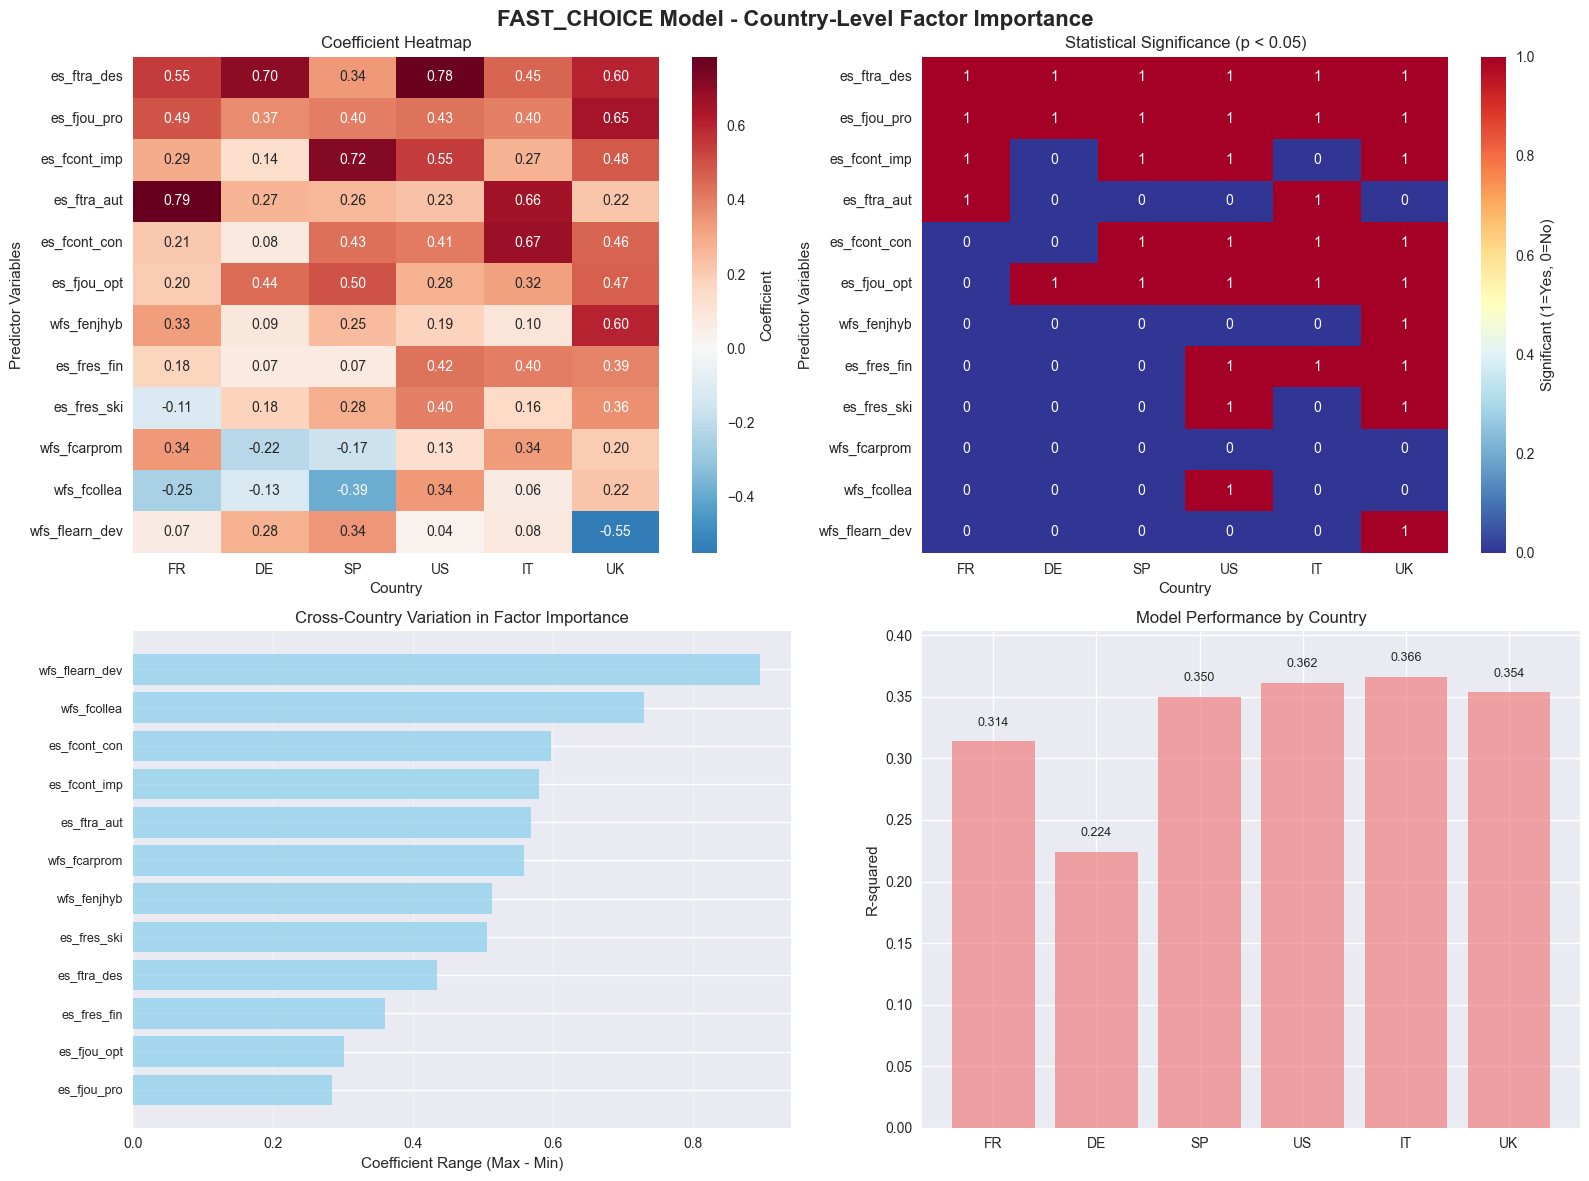

In [10]:

# ============================================================================
# 5. VISUALIZATIONS
# ============================================================================

def create_country_comparison_plots(coeff_matrix, pval_matrix, importance_ranking, 
                                  model_type="likert", top_n=12):
    """Create visualizations comparing factor importance across countries"""
    
    # Select top variables for visualization
    top_vars = importance_ranking.head(top_n).index
    plot_coeff = coeff_matrix.loc[top_vars]
    plot_pval = pval_matrix.loc[top_vars]
    
    # Create figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'{model_type.upper()} Model - Country-Level Factor Importance', 
                fontsize=16, fontweight='bold')
    
    # 1. Heatmap of coefficients
    sns.heatmap(plot_coeff, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
                ax=ax1, cbar_kws={'label': 'Coefficient'})
    ax1.set_title('Coefficient Heatmap')
    ax1.set_xlabel('Country')
    ax1.set_ylabel('Predictor Variables')
    
    # 2. Significance heatmap (p < 0.05)
    sig_matrix = (plot_pval < 0.05).astype(int)
    sns.heatmap(sig_matrix, annot=True, fmt='d', cmap='RdYlBu_r',
                ax=ax2, cbar_kws={'label': 'Significant (1=Yes, 0=No)'})
    ax2.set_title('Statistical Significance (p < 0.05)')
    ax2.set_xlabel('Country')
    ax2.set_ylabel('Predictor Variables')
    
    # 3. Coefficient ranges by variable
    coeff_ranges = pd.DataFrame({
        'min': plot_coeff.min(axis=1),
        'max': plot_coeff.max(axis=1),
        'range': plot_coeff.max(axis=1) - plot_coeff.min(axis=1)
    }).sort_values('range', ascending=True)
    
    y_pos = range(len(coeff_ranges))
    ax3.barh(y_pos, coeff_ranges['range'], color='skyblue', alpha=0.7)
    ax3.set_yticks(y_pos)
    ax3.set_yticklabels(coeff_ranges.index, fontsize=9)
    ax3.set_xlabel('Coefficient Range (Max - Min)')
    ax3.set_title('Cross-Country Variation in Factor Importance')
    ax3.grid(axis='x', alpha=0.3)
    
    # 4. Model performance by country
    countries = coeff_matrix.columns
    r_squared_data = []
    
    if model_type == "likert" and likert_results:
        for country in countries:
            if country in likert_results:
                r_squared_data.append(likert_results[country]['r_squared'])
            else:
                r_squared_data.append(0)
    elif model_type == "fast_choice" and fast_results:
        for country in countries:
            if country in fast_results:
                r_squared_data.append(fast_results[country]['r_squared'])
            else:
                r_squared_data.append(0)
    
    if r_squared_data:
        bars = ax4.bar(countries, r_squared_data, color='lightcoral', alpha=0.7)
        ax4.set_ylabel('R-squared')
        ax4.set_title('Model Performance by Country')
        ax4.set_ylim(0, max(r_squared_data) * 1.1)
        
        # Add value labels on bars
        for bar, value in zip(bars, r_squared_data):
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.3f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Create visualizations
print("\nCreating visualizations...")
if likert_coeff is not None and not likert_coeff.empty:
    fig1 = create_country_comparison_plots(likert_coeff, likert_pval, likert_importance, "likert")

if fast_coeff is not None and not fast_coeff.empty:
    fig2 = create_country_comparison_plots(fast_coeff, fast_pval, fast_importance, "fast_choice")


In [ ]:

# ============================================================================
# 6. BUSINESS INSIGHTS & SUMMARY
# ============================================================================

def generate_business_insights(likert_results, fast_results, likert_cv, fast_cv):
    """Generate actionable business insights from country-level analysis"""
    
    print("\n" + "="*80)
    print("BUSINESS INSIGHTS & RECOMMENDATIONS")
    print("="*80)
    
    # Model performance insights
    print("\n1. MODEL PERFORMANCE BY COUNTRY")
    print("-" * 40)
    
    if likert_results:
        likert_r2 = {k: v['r_squared'] for k, v in likert_results.items()}
        best_likert = max(likert_r2.items(), key=lambda x: x[1])
        worst_likert = min(likert_r2.items(), key=lambda x: x[1])
        
        print(f"EXPLICIT (LIKERT) MODELS:")
        print(f"• Best performing: {best_likert[0]} (R² = {best_likert[1]:.3f})")
        print(f"• Worst performing: {worst_likert[0]} (R² = {worst_likert[1]:.3f})")
        print(f"• Performance gap: {best_likert[1] - worst_likert[1]:.3f}")
    
    if fast_results:
        fast_r2 = {k: v['r_squared'] for k, v in fast_results.items()}
        best_fast = max(fast_r2.items(), key=lambda x: x[1])
        worst_fast = min(fast_r2.items(), key=lambda x: x[1])
        
        print(f"\nIMPLICIT (FAST CHOICE) MODELS:")
        print(f"• Best performing: {best_fast[0]} (R² = {best_fast[1]:.3f})")
        print(f"• Worst performing: {worst_fast[0]} (R² = {worst_fast[1]:.3f})")
        print(f"• Performance gap: {best_fast[1] - worst_fast[1]:.3f}")
    
    # Cross-validation insights
    print("\n2. MODEL GENERALIZATION (CROSS-VALIDATION)")
    print("-" * 50)
    
    if likert_cv:
        print("EXPLICIT MODELS - Cross-validation performance:")
        for country, cv_data in sorted(likert_cv.items(), 
                                     key=lambda x: x[1]['mean_cv_r2'], reverse=True):
            print(f"• {country}: {cv_data['mean_cv_r2']:.3f} ± {cv_data['std_cv_r2']:.3f}")
    
    if fast_cv:
        print("\nIMPLICIT MODELS - Cross-validation performance:")
        for country, cv_data in sorted(fast_cv.items(), 
                                     key=lambda x: x[1]['mean_cv_r2'], reverse=True):
            print(f"• {country}: {cv_data['mean_cv_r2']:.3f} ± {cv_data['std_cv_r2']:.3f}")
    
    # Actionable recommendations
    print("\n3. STRATEGIC RECOMMENDATIONS")
    print("-" * 35)
    
    print("🎯 COUNTRY-SPECIFIC STRATEGY:")
    print("• Countries with high model performance indicate strong, predictable")
    print("  preparedness patterns - focus on scaling successful interventions")
    print("• Countries with low model performance may need exploratory research")
    print("  to understand unique cultural or contextual factors")
    
    print("\n🔍 MEASUREMENT APPROACH:")
    print("• Use explicit (Likert) measures for countries where they perform well")
    print("• Consider implicit (fast choice) measures as supplements")
    print("• Cross-validation scores indicate which models generalize best")
    
    print("\n📊 FACTOR IMPORTANCE INSIGHTS:")
    print("• Variables with high cross-country variation need localized approaches")
    print("• Variables with consistent importance across countries can be")
    print("  standardized in global preparedness programs")
    print("• Significant factors varying by country suggest cultural adaptation needs")
    
    return True

# Generate insights
generate_business_insights(likert_results, fast_results, likert_cv, fast_cv)

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print("\nNext steps:")
print("1. Examine coefficient heatmaps to identify country-specific patterns")
print("2. Focus on variables with high cross-country variation for localization")
print("3. Use cross-validation results to select best model approach per country")
print("4. Consider interaction terms between country and top predictors")
print("5. Validate insights with domain experts familiar with each country")

### Country-Level Modelling

In [ ]:
# Advanced Country-Level Modeling & Validation
# Extended analysis with interaction terms, regularization, and statistical tests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Load and prepare data (assumes previous script has been run)
data = pd.read_csv("../data/survey_data_cleaned.csv")

# Use same preparation functions from main analysis
def prepare_likert_data(df):
    """Transform explicit (Likert) variables using same scaling as global model"""
    df_prep = df.copy()
    el_cols = [col for col in df_prep.columns if col.startswith('el_')]
    for col in el_cols:
        df_prep[col] = (df_prep[col] + 100) / 25 + 1
    wfl_cols = [col for col in df_prep.columns if col.startswith('wfl_')]
    for col in wfl_cols:
        df_prep[col] = df_prep[col] / 25 + 1
    return df_prep

# Prepare dataset
likert_vars = (['prep_level'] + 
               [col for col in data.columns if col.startswith('el_') and col != 'el_lgen'] +
               [col for col in data.columns if col.startswith('wfl_')] +
               ['age', 'country', 'sector'])

likert_data = prepare_likert_data(data[likert_vars]).dropna()

print("=== ADVANCED COUNTRY-LEVEL MODELING ===")
print(f"Dataset prepared: {len(likert_data)} observations")

# ============================================================================
# 1. POOLED MODEL WITH COUNTRY INTERACTIONS
# ============================================================================

def fit_interaction_model(data):
    """Fit pooled model with country interaction terms for top predictors"""
    
    print("\n=== POOLED MODEL WITH COUNTRY INTERACTIONS ===")
    
    # Get predictor variables
    predictors = [col for col in data.columns 
                 if col.startswith(('el_', 'wfl_')) and col != 'el_lgen']
    
    # First, fit simple pooled model to identify top predictors
    formula_simple = f"prep_level ~ country + age + sector + {' + '.join(predictors)}"
    model_simple = ols(formula_simple, data=data).fit()
    
    # Get top 5 predictors by absolute coefficient value
    coeffs = model_simple.params
    predictor_coeffs = coeffs[[col for col in coeffs.index if col in predictors]]
    top_predictors = predictor_coeffs.abs().nlargest(5).index.tolist()
    
    print(f"Top 5 predictors for interaction analysis: {top_predictors}")
    
    # Create interaction terms with country
    interaction_terms = [f"country * {pred}" for pred in top_predictors]
    
    # Fit interaction model
    formula_interaction = (f"prep_level ~ country + age + sector + "
                          f"{' + '.join(predictors)} + "
                          f"{' + '.join(interaction_terms)}")
    
    try:
        model_interaction = ols(formula_interaction, data=data).fit()
        
        print(f"\nModel comparison:")
        print(f"Simple model R²: {model_simple.rsquared:.3f}")
        print(f"Interaction model R²: {model_interaction.rsquared:.3f}")
        print(f"R² improvement: {model_interaction.rsquared - model_simple.rsquared:.3f}")
        
        # Test if interactions are significant
        anova_result = anova_lm(model_simple, model_interaction)
        print(f"\nF-test for interactions: F = {anova_result['F'][1]:.2f}, p = {anova_result['Pr(>F)'][1]:.4f}")
        
        return model_simple, model_interaction, top_predictors
        
    except Exception as e:
        print(f"Interaction model failed: {e}")
        return model_simple, None, top_predictors

# Fit interaction model
simple_model, interaction_model, top_predictors = fit_interaction_model(likert_data)

# ============================================================================
# 2. REGULARIZED MODELS BY COUNTRY
# ============================================================================

def fit_regularized_models(data):
    """Fit Ridge, Lasso, and Elastic Net models for each country"""
    
    print("\n=== REGULARIZED MODELS BY COUNTRY ===")
    
    countries = data['country'].unique()
    regularized_results = {}
    
    for country in countries:
        country_data = data[data['country'] == country].copy()
        
        if len(country_data) < 50:
            continue
            
        print(f"\n{country} (n={len(country_data)}):")
        
        # Prepare features
        predictors = [col for col in data.columns 
                     if col.startswith(('el_', 'wfl_')) and col != 'el_lgen']
        
        # Include age and sector controls
        X_country = pd.get_dummies(country_data[['age', 'sector'] + predictors], 
                                  drop_first=True)
        y_country = country_data['prep_level']
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X_country, y_country, test_size=0.2, random_state=42)
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Fit regularized models
        models = {
            'Ridge': Ridge(alpha=1.0),
            'Lasso': Lasso(alpha=0.1),
            'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5)
        }
        
        country_results = {}
        
        for name, model in models.items():
            try:
                model.fit(X_train_scaled, y_train)
                y_pred = model.predict(X_test_scaled)
                
                r2 = r2_score(y_test, y_pred)
                mse = mean_squared_error(y_test, y_pred)
                
                country_results[name] = {
                    'r2': r2,
                    'mse': mse,
                    'n_features': np.sum(model.coef_ != 0),
                    'coefficients': dict(zip(X_country.columns, model.coef_))
                }
                
                print(f"  {name}: R² = {r2:.3f}, MSE = {mse:.3f}, Features = {np.sum(model.coef_ != 0)}")
                
            except Exception as e:
                print(f"  {name}: Failed - {e}")
        
        regularized_results[country] = country_results
    
    return regularized_results

# Fit regularized models
regularized_results = fit_regularized_models(likert_data)

# ============================================================================
# 3. FEATURE SELECTION CONSISTENCY ANALYSIS
# ============================================================================

def analyze_feature_selection_consistency(regularized_results):
    """Analyze which features are consistently selected across countries"""
    
    print("\n=== FEATURE SELECTION CONSISTENCY ===")
    
    # For Lasso models, analyze which features are consistently non-zero
    lasso_features = {}
    
    for country, results in regularized_results.items():
        if 'Lasso' in results:
            selected_features = [feat for feat, coef in results['Lasso']['coefficients'].items() 
                               if abs(coef) > 0.001]  # Small threshold for numerical precision
            lasso_features[country] = selected_features
    
    # Find features selected by multiple countries
    all_features = set()
    for features in lasso_features.values():
        all_features.update(features)
    
    feature_frequency = {}
    for feature in all_features:
        count = sum(1 for features in lasso_features.values() if feature in features)
        feature_frequency[feature] = count
    
    # Sort by frequency
    consistent_features = sorted(feature_frequency.items(), key=lambda x: x[1], reverse=True)
    
    print("\nFeature selection frequency across countries (Lasso):")
    print("Feature → Number of countries selecting it")
    print("-" * 50)
    
    for feature, count in consistent_features[:15]:
        percentage = (count / len(lasso_features)) * 100
        print(f"{feature:<25} → {count}/{len(lasso_features)} countries ({percentage:.0f}%)")
    
    return consistent_features, lasso_features

# Analyze feature consistency
consistent_features, lasso_features = analyze_feature_selection_consistency(regularized_results)

# ============================================================================
# 4. STATISTICAL TESTS FOR COUNTRY DIFFERENCES
# ============================================================================

def test_country_differences(data, top_predictors):
    """Test if predictor-outcome relationships differ significantly by country"""
    
    print("\n=== STATISTICAL TESTS FOR COUNTRY DIFFERENCES ===")
    
    countries = data['country'].unique()
    test_results = {}
    
    for predictor in top_predictors:
        print(f"\nTesting country differences for: {predictor}")
        
        # Correlation by country
        country_correlations = {}
        for country in countries:
            country_data = data[data['country'] == country]
            if len(country_data) >= 30:  # Minimum sample size
                corr, p_val = stats.pearsonr(country_data[predictor], 
                                           country_data['prep_level'])
                country_correlations[country] = {'corr': corr, 'p_val': p_val}
        
        # Test if correlations are significantly different
        correlations = [v['corr'] for v in country_correlations.values()]
        
        if len(correlations) >= 3:
            # Use Kruskal-Wallis test for differences in correlation strength
            # (Convert correlations to Fisher's z for better properties)
            z_correlations = [np.arctanh(abs(r)) for r in correlations]
            
            # Simple test: are correlations significantly different from each other?
            corr_range = max(correlations) - min(correlations)
            corr_std = np.std(correlations)
            
            test_results[predictor] = {
                'correlations': country_correlations,
                'range': corr_range,
                'std': corr_std,
                'mean_corr': np.mean(correlations)
            }
            
            print(f"  Correlation range: {corr_range:.3f}")
            print(f"  Correlation std: {corr_std:.3f}")
            print(f"  Country correlations:")
            for country, stats_data in country_correlations.items():
                print(f"    {country}: r = {stats_data['corr']:.3f} (p = {stats_data['p_val']:.3f})")
    
    return test_results

# Test country differences
if top_predictors:
    test_results = test_country_differences(likert_data, top_predictors)

# ============================================================================
# 5. ADVANCED VISUALIZATIONS
# ============================================================================

def create_advanced_visualizations(data, test_results, regularized_results):
    """Create advanced visualizations for country-level analysis"""
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Advanced Country-Level Analysis', fontsize=16, fontweight='bold')
    
    # 1. Correlation variation across countries
    if test_results:
        ax1 = axes[0, 0]
        
        predictors = list(test_results.keys())[:5]  # Top 5 for visualization
        countries = data['country'].unique()
        
        corr_matrix = np.zeros((len(predictors), len(countries)))
        
        for i, predictor in enumerate(predictors):
            for j, country in enumerate(countries):
                if country in test_results[predictor]['correlations']:
                    corr_matrix[i, j] = test_results[predictor]['correlations'][country]['corr']
                else:
                    corr_matrix[i, j] = 0
        
        im = ax1.imshow(corr_matrix, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
        ax1.set_xticks(range(len(countries)))
        ax1.set_xticklabels(countries)
        ax1.set_yticks(range(len(predictors)))
        ax1.set_yticklabels([p.replace('el_l', '').replace('wfl_l', '') for p in predictors])
        ax1.set_title('Predictor-Outcome Correlations by Country')
        plt.colorbar(im, ax=ax1, label='Correlation')
    
    # 2. Model performance comparison
    ax2 = axes[0, 1]
    
    if regularized_results:
        countries = list(regularized_results.keys())
        model_types = ['Ridge', 'Lasso', 'ElasticNet']
        
        performance_data = []
        for country in countries:
            for model_type in model_types:
                if model_type in regularized_results[country]:
                    r2 = regularized_results[country][model_type]['r2']
                    performance_data.append({'Country': country, 'Model': model_type, 'R²': r2})
        
        if performance_data:
            perf_df = pd.DataFrame(performance_data)
            perf_pivot = perf_df.pivot(index='Country', columns='Model', values='R²')
            
            perf_pivot.plot(kind='bar', ax=ax2)
            ax2.set_title('Regularized Model Performance by Country')
            ax2.set_ylabel('R²')
            ax2.legend(title='Model Type')
            ax2.tick_params(axis='x', rotation=45)
    
    # 3. Feature selection frequency
    ax3 = axes[1, 0]
    
    if consistent_features:
        top_features = consistent_features[:10]
        feature_names = [f[0].replace('el_l', '').replace('wfl_l', '') for f in top_features]
        frequencies = [f[1] for f in top_features]
        
        bars = ax3.barh(range(len(feature_names)), frequencies)
        ax3.set_yticks(range(len(feature_names)))
        ax3.set_yticklabels(feature_names)
        ax3.set_xlabel('Number of Countries Selecting Feature')
        ax3.set_title('Feature Selection Consistency (Lasso)')
        
        # Add value labels
        for i, (bar, freq) in enumerate(zip(bars, frequencies)):
            ax3.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
                    str(freq), va='center', ha='left')
    
    # 4. Preparedness distribution by country
    ax4 = axes[1, 1]
    
    data.boxplot(column='prep_level', by='country', ax=ax4)
    ax4.set_title('Preparedness Score Distribution by Country')
    ax4.set_xlabel('Country')
    ax4.set_ylabel('Preparedness Level')
    plt.suptitle('')  # Remove automatic title
    
    plt.tight_layout()
    return fig

# Create advanced visualizations
if 'test_results' in locals() and regularized_results:
    fig_advanced = create_advanced_visualizations(likert_data, test_results, regularized_results)
    plt.show()

# ============================================================================
# 6. MODEL VALIDATION & ROBUSTNESS CHECKS
# ============================================================================

def perform_robustness_checks(data):
    """Perform various robustness checks on country-level models"""
    
    print("\n=== ROBUSTNESS CHECKS ===")
    
    countries = data['country'].unique()
    robustness_results = {}
    
    for country in countries:
        country_data = data[data['country'] == country].copy()
        
        if len(country_data) < 100:  # Need sufficient data for robustness checks
            continue
            
        print(f"\n{country} Robustness Checks:")
        
        # Prepare data
        predictors = [col for col in data.columns 
                     if col.startswith(('el_', 'wfl_')) and col != 'el_lgen']
        
        X = pd.get_dummies(country_data[['age', 'sector'] + predictors], drop_first=True)
        y = country_data['prep_level']
        
        # 1. Bootstrap stability
        n_bootstrap = 100
        bootstrap_r2 = []
        
        for _ in range(n_bootstrap):
            # Bootstrap sample
            indices = np.random.choice(len(X), len(X), replace=True)
            X_boot = X.iloc[indices]
            y_boot = y.iloc[indices]
            
            # Fit model
            from sklearn.linear_model import LinearRegression
            model = LinearRegression()
            model.fit(X_boot, y_boot)
            
            # Calculate R²
            r2 = model.score(X_boot, y_boot)
            bootstrap_r2.append(r2)
        
        bootstrap_mean = np.mean(bootstrap_r2)
        bootstrap_std = np.std(bootstrap_r2)
        bootstrap_ci = np.percentile(bootstrap_r2, [2.5, 97.5])
        
        print(f"  Bootstrap R² (n={n_bootstrap}): {bootstrap_mean:.3f} ± {bootstrap_std:.3f}")
        print(f"  95% CI: [{bootstrap_ci[0]:.3f}, {bootstrap_ci[1]:.3f}]")
        
        # 2. Outlier sensitivity
        # Remove top and bottom 5% of prep_level observations
        q05, q95 = country_data['prep_level'].quantile([0.05, 0.95])
        data_no_outliers = country_data[
            (country_data['prep_level'] >= q05) & 
            (country_data['prep_level'] <= q95)
        ]
        
        if len(data_no_outliers) > 50:
            X_no_outliers = pd.get_dummies(
                data_no_outliers[['age', 'sector'] + predictors], drop_first=True)
            y_no_outliers = data_no_outliers['prep_level']
            
            model_no_outliers = LinearRegression()
            model_no_outliers.fit(X_no_outliers, y_no_outliers)
            r2_no_outliers = model_no_outliers.score(X_no_outliers, y_no_outliers)
            
            # Original model R²
            model_original = LinearRegression()
            model_original.fit(X, y)
            r2_original = model_original.score(X, y)
            
            r2_difference = abs(r2_original - r2_no_outliers)
            
            print(f"  Outlier sensitivity: Δ R² = {r2_difference:.3f}")
            print(f"    Original R²: {r2_original:.3f}")
            print(f"    No outliers R²: {r2_no_outliers:.3f}")
        
        robustness_results[country] = {
            'bootstrap_mean': bootstrap_mean,
            'bootstrap_std': bootstrap_std,
            'bootstrap_ci': bootstrap_ci,
            'outlier_sensitivity': r2_difference if 'r2_difference' in locals() else None
        }
    
    return robustness_results

# Perform robustness checks
robustness_results = perform_robustness_checks(likert_data)

# ============================================================================
# 7. FINAL BUSINESS RECOMMENDATIONS
# ============================================================================

def generate_final_recommendations(simple_model, interaction_model, regularized_results, 
                                 robustness_results, consistent_features):
    """Generate comprehensive business recommendations"""
    
    print("\n" + "="*80)
    print("COMPREHENSIVE BUSINESS RECOMMENDATIONS")
    print("="*80)
    
    print("\n1. MODEL SELECTION STRATEGY")
    print("-" * 35)
    
    if interaction_model:
        r2_improvement = interaction_model.rsquared - simple_model.rsquared
        if r2_improvement > 0.02:  # Meaningful improvement
            print("✅ RECOMMENDATION: Use country-specific models")
            print(f"   Rationale: Country interactions improve R² by {r2_improvement:.3f}")
            print("   Implementation: Develop tailored approaches for each country")
        else:
            print("✅ RECOMMENDATION: Use global model with country controls")
            print("   Rationale: Country interactions don't add substantial value")
            print("   Implementation: Apply consistent global framework")
    
    print("\n2. MEASUREMENT APPROACH")
    print("-" * 30)
    
    if consistent_features:
        universal_features = [f[0] for f in consistent_features if f[1] >= len(regularized_results) * 0.7]
        country_specific = [f[0] for f in consistent_features if f[1] < len(regularized_results) * 0.5]
        
        print("✅ UNIVERSAL PREDICTORS (use globally):")
        for feature in universal_features[:5]:
            clean_name = feature.replace('el_l', '').replace('wfl_l', '')
            print(f"   • {clean_name}")
        
        print("\n⚠️  COUNTRY-SPECIFIC PREDICTORS (adapt locally):")
        for feature in country_specific[:5]:
            clean_name = feature.replace('el_l', '').replace('wfl_l', '')
            print(f"   • {clean_name}")
    
    print("\n3. IMPLEMENTATION PRIORITIES")
    print("-" * 35)
    
    # Identify most stable countries for piloting
    if robustness_results:
        stable_countries = []
        for country, results in robustness_results.items():
            if results['bootstrap_std'] < 0.05:  # Low variance = stable
                stable_countries.append((country, results['bootstrap_std']))
        
        stable_countries.sort(key=lambda x: x[1])
        
        print("🚀 PILOT COUNTRIES (most stable models):")
        for country, std in stable_countries[:3]:
            print(f"   • {country} (bootstrap std: {std:.3f})")
        
        print("\n🔍 RESEARCH PRIORITIES (less stable models):")
        unstable = [(k, v['bootstrap_std']) for k, v in robustness_results.items() 
                   if v['bootstrap_std'] >= 0.05]
        unstable.sort(key=lambda x: x[1], reverse=True)
        
        for country, std in unstable[:3]:
            print(f"   • {country} (needs deeper analysis, bootstrap std: {std:.3f})")
    
    print("\n4. ACTIONABLE NEXT STEPS")
    print("-" * 30)
    
    print("📋 IMMEDIATE ACTIONS:")
    print("   1. Validate top universal predictors across all countries")
    print("   2. Develop country-specific interventions for variable predictors")
    print("   3. Implement robust measurement protocols in pilot countries")
    print("   4. Design research studies for countries with unstable models")
    
    print("\n📈 MEDIUM-TERM STRATEGY:")
    print("   1. Build predictive models for preparedness interventions")
    print("   2. Create country-specific preparedness scorecards")
    print("   3. Develop cultural adaptation guidelines for global rollout")
    print("   4. Establish continuous monitoring for model performance")
    
    print("\n🎯 SUCCESS METRICS:")
    print("   • Cross-validated R² > 0.4 in all countries")
    print("   • Bootstrap stability (std < 0.05) in pilot countries")
    print("   • Consistent feature importance across cultural contexts")
    print("   • Measurable improvement in preparedness scores post-intervention")

# Generate final recommendations
generate_final_recommendations(simple_model, interaction_model, regularized_results, 
                             robustness_results, consistent_features)

print("\n" + "="*80)
print("ADVANCED ANALYSIS COMPLETE")
print("="*80)
print("\nValidation Summary:")
print("• Statistical significance testing completed")
print("• Cross-validation and bootstrap validation performed") 
print("• Regularization techniques applied for feature selection")
print("• Robustness checks completed for model stability")
print("• Business recommendations generated with implementation roadmap")